In this notebook I applied geopandas and pandas to plot background map, the IRS seismic data, and the Focal mechanism beach balls.  

In [1]:
#should be activate mysw4 conda env
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
%matplotlib inline
names=[ 'date','lat','lon','smajax' , 'sminax' , 'strike', 'q1' , 'depth' ,'unc1' , 'q2' ,
        'mw',  'unc2' , 'q3' , 's' ,'mo','fac', 'mo_auth','mpp','mpr','mrr','mrt','mtp','mtt' 
        ,'str1','dip1','rake1','str2','dip2','rake2','type','eventid' ]

df1 = pd.read_csv("/localdata/rayan/ISC_cataloges_2020/isc-gem-cat.csv",error_bad_lines=False,
               skiprows=lambda x: x in [0, 94], skipinitialspace=True ,names=names, comment='#')
##lon1,lon2,lat1,lat2 for USA
R=[-60.00,-120.00,20.00,60.00]
mw=80
df_fm=df1[["strike","dip2","rake2","lat","lon"]]
df=df1[(df1['lon']<R[0]) & (df1['lon']>R[1])&(df1['lat']>R[2]) & (df1['lat']<R[3])&(df1['mw']<mw)]
#df.head()
##to use clip comment
polygon = Polygon([(-35, 0), (-35, 60), (60, 60), (60, 0), (0, 0)]);
polygon_US=Polygon([(-125, 15), (-125, 70), (-10, 70), (-10,15)]);

## Importing shipfiles 

In [62]:
#
#regions = gpd.read_file("/localdata/rayan/ISC_cataloges_2020/Countries_WGS84/Countries_WGS84.shp")
#print(regions.crs)


regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plate_oregens=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_orogens.shp")
plate_steps=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_steps.shp")
plate_plates=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_plates.shp")
plate_boundary=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_boundaries.shp")
prov_lines_US=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonic_provinces_shapefile/prov_lines.shp")
physio_US=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/physio_shapfile/physio.shp")
regions.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [64]:
physio_US.head(2)

,AREA,PERIMETER,PHYSIODD_,PHYSIODD_I,FCODE,FENCODE,DIVISION,PROVINCE,SECTION,PROVCODE,geometry
0,40.121,36.938,2,72,122,12b,INTERIOR PLAINS,CENTRAL LOWLAND,WESTERN LAKE,12,"POLYGON ((-103.00201 49.00395, -102.94103 49.0..."
1,21.976,39.951,3,59,131,13a,INTERIOR PLAINS,GREAT PLAINS,"MISSOURI PLATEAU, GLACIATED",13,"POLYGON ((-113.55362 48.99719, -112.19278 48.9..."


In [75]:
df1.head(1)

,date,lat,lon,smajax,sminax,strike,q1,depth,unc1,q2,...,mtt,str1,dip1,rake1,str2,dip2,rake2,type,eventid,geometry
0,1904-04-04 10:02:34.56,41.802,23.108,8.6,6.6,164.2,B,15.0,4.8,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,610326271,POINT (23.10800 41.80200)


the coordinate reference system: epsg:4326


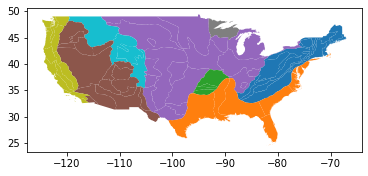

In [49]:
print('the coordinate reference system:',regions.crs) #coordinate reference system
NA = regions[regions["continent"] == "North America"]
physio_US.head()
physio_US.plot(column='DIVISION');

the coordinate reference system: epsg:4326


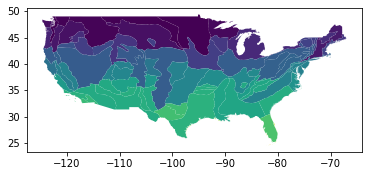

In [50]:
print('the coordinate reference system:',regions.crs) #coordinate reference system
NA = regions[regions["continent"] == "North America"]
physio_US.head()
physio_US.plot(column='PHYSIODD_');

the coordinate reference system: epsg:4326


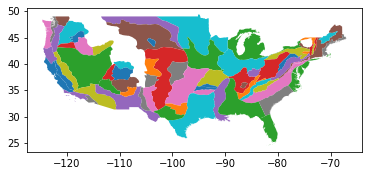

In [110]:
print('the coordinate reference system:',regions.crs) #coordinate reference system
NA = regions[regions["continent"] == "North America"]
physio_US.head()
physio_US.plot(column='SECTION');

## Plot the Plate boudaries (we can select any continent)

/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


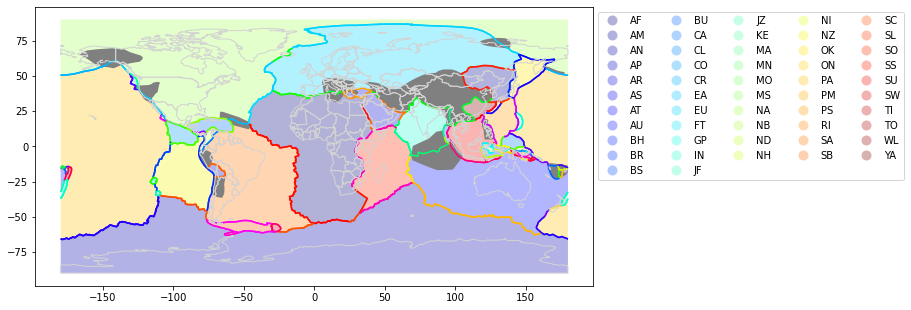

In [56]:
fig_test, ax_test=plt.subplots(figsize=(10,10))
plate_oregens.plot(ax=ax_test,column="Name",color='gray',zorder=3)
plate_steps.plot(ax=ax_test,column="PLATEBOUND",cmap='hsv',zorder=2)
plate_plates.plot(ax=ax_test,column="Code",cmap='jet',zorder=1,alpha=0.3,legend=True,legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1),ncol=5))
plate_boundary.plot(ax=ax_test,column="Name",cmap='hsv',zorder=4)
regions.plot(ax=ax_test,facecolor="none", edgecolor="lightgray", linestyle='-',zorder=5)


## Convert the IRIS DataFrame to a GeoDataFrame

In [19]:
df_geo = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat))
# Set the coordinate reference system (CRS) to EPSG 4326
df_geo.crs = {'init': 'epsg:4326'}
#df_geo.crs = {'epsg':4326}

#df_geo.head()

/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [45]:
#[df_geo.lat> R[3] & df_geo.lat <R[3] & df_geo.lon>R[0]  & df_geo.lon<R[1]]
df_geo_usa=df_geo[((df_geo.lat<= R[3]) & (df_geo.lat > R[2]))&(df_geo.lon<R[0])  & (df_geo.lon>R[1])]

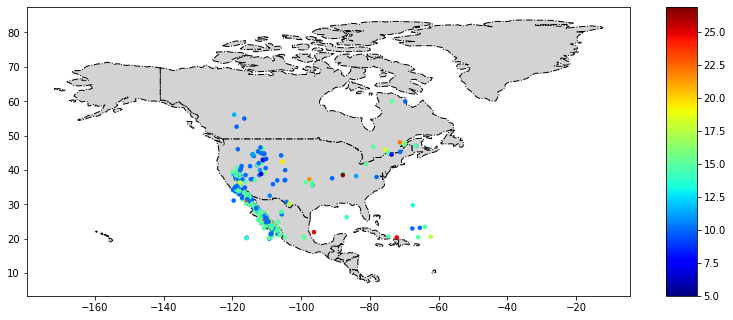

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # to control the color bar
fig, ax = plt.subplots(figsize=(12,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
NA.plot(ax=ax,color='lightgray', linestyle='-.', edgecolor='black',zorder=1)
df_geo_usa.to_crs(epsg=4326).plot(markersize=50, ax=ax,column='depth',legend=True,cmap='jet',marker='.',zorder=2,cax=cax)

## plot mag 

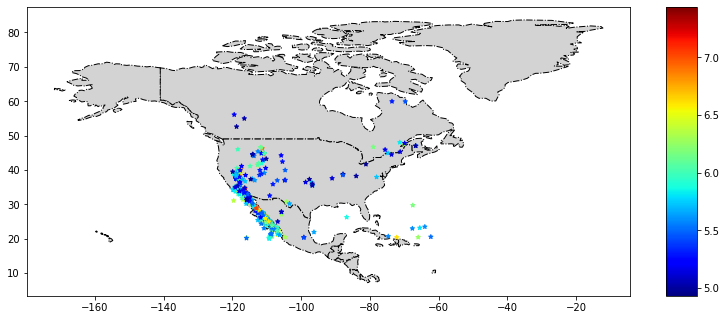

In [67]:
fig, ax = plt.subplots(figsize=(12,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
NA.plot(ax=ax,color='lightgray', linestyle='-.', edgecolor='black',zorder=1)
df_geo_usa.to_crs(epsg=4326).plot(markersize=20, ax=ax,column='mw',legend=True,cmap='jet',marker='*',zorder=2,cax=cax)

## clipping all the layers using clip method

/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 

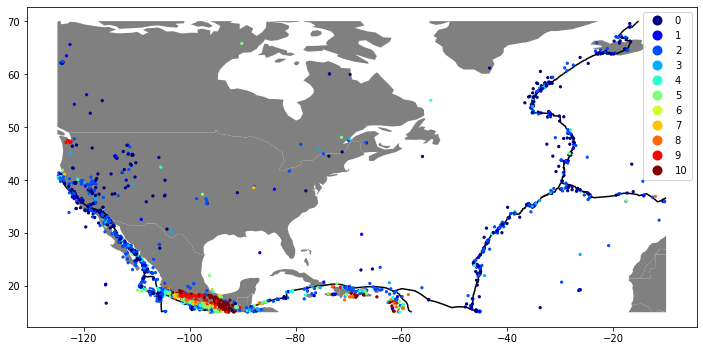

In [68]:
import mapclassify as mc


fig1, ax1 = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'});
clipped_R = gpd.clip(regions, polygon);
clipped_US = gpd.clip(regions, polygon_US);
clipped_E = gpd.clip(df_geo, polygon_US);
clipped_plates = gpd.clip(plate_boundary, polygon_US).plot(ax=ax1, facecolor="none", edgecolor="black",zorder=2)
clipped_US.plot(ax=ax1, color='gray',zorder=1);
clipped_E_Quant=mc.Quantiles(clipped_E['depth'],k=20);

clipped_E.assign(cl=clipped_E_Quant.yb).plot(column='cl', categorical=True, \
                              k=10, ax=ax1, cmap='jet',zorder=3,legend=True,markersize=5);

In [946]:
ax1.title.set_text('IRIS_EQ')
fig1.savefig('IRIS_q10.png')

In [117]:
#focal mechanism exmaples
polygon_data=Polygon([(-125, 20), (-125, 50), (-120, 50), (-120,20)]);
#polygon_map=Polygon([(-125, 15), (-125, 70), (-10, 70), (-10,15)]);
polygon_map=Polygon([(-125, 20), (-125, 50), (-115, 50), (-115,20)]);
from obspy.imaging.beachball import beach,beachball
df_fm1=df_fm.dropna().sort_values(by=['lat','lon'],ascending=False).reset_index()
del df_fm1['index']


/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rayan/anaconda3/envs/mysw4/lib/python3.6/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


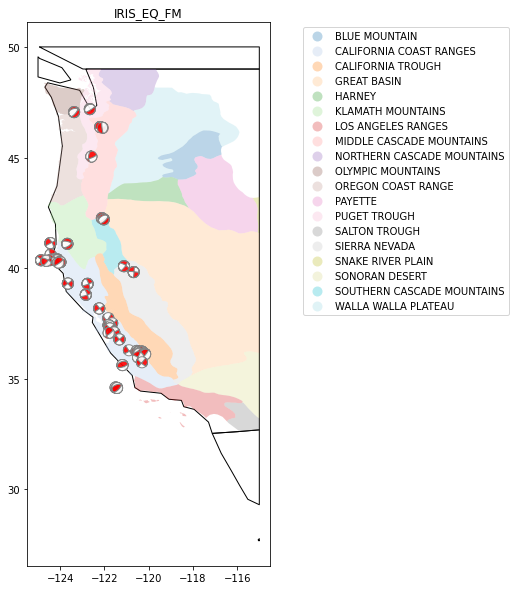

In [147]:
#plot focal mechanism on maps
df_fm_geo = gpd.GeoDataFrame(df_fm1, geometry=gpd.points_from_xy(df_fm1.lon, df_fm1.lat))
df_fm_geo.crs = {'init': 'epsg:4326'}
fig_fm,ax_fm=plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'});
df_fm_geo_clip=gpd.clip(df_fm_geo,polygon_data)
physio_US['geometry'] = physio_US.buffer(0)
gpd.clip(regions,polygon_map).plot(ax=ax_fm,facecolor="none", edgecolor="black", linestyle='-',zorder=1)
gpd.clip(physio_US,polygon_map).plot(column='SECTION',ax=ax_fm,alpha=0.3,zorder=2,label='Physio',legend=True,categorical=True,cmap='tab20');
for row in df_fm_geo_clip.iloc[0:,0:8].itertuples(name=None):
   mt=row[1:4];
   y=row[4];
   x=row[5];
   path='/localdata/rayan/ISC_cataloges_2020/Stressinverse_1'
   out_filename=path+'/Data/IRIS_test.dat'
   #f_mt = float('.'.join(str(ele) for ele in mt))
   with open(out_filename, 'a') as out_file:
     out_file.write(f"  {row[1]:0.2e}  {row[2]:0.2e}  {row[3]:0.2e}\n")
    
   #print('focal mechanism factors mt={0} and lon={1} and lat= {2}'.format(mt,x,y))
   b=beach(mt, xy=(x, y), width=0.5, linewidth=1, alpha=0.9,facecolor='r',edgecolor="gray")
   b.set_zorder(3)
   bc=ax_fm.add_collection(b)
leg=ax_fm.get_legend()
leg.set_bbox_to_anchor((2,1))
ax_fm.title.set_text('IRIS_EQ_FM')
fig_fm.savefig('IRIS_FM.png')  
  
   